In [ ]:
#implementation from https://huggingface.co/docs/transformers/main/model_doc/blip-2
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

img_url = 'https://images.pexels.com/photos/1629781/pexels-photo-1629781.jpeg?auto=compress&cs=tinysrgb&w=800'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

contains_person = True

# Conditional image captioning
text = "a photography of"
inputs = processor(raw_image, text, return_tensors="pt")
out = model.generate(**inputs)
conditional_caption = processor.decode(out[0], skip_special_tokens=True)

# Unconditional image captioning
inputs = processor(raw_image, return_tensors="pt")
out = model.generate(**inputs)
unconditional_caption = processor.decode(out[0], skip_special_tokens=True)

# Store in variables
conditional_caption_variable = processor.decode(out[0], skip_special_tokens=True)
unconditional_caption_variable = processor.decode(out[0], skip_special_tokens=True)

# Because we don't know which caption to print
if contains_person:
    text_caption = conditional_caption_variable
else:
    text_caption = unconditional_caption_variable

print("Input:", text_caption)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Input: there is a dog wearing sunglasses and a collar with a collar


In [ ]:
#initializing functions used for extracting keywords
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import networkx as nx

nltk.download('punkt')
nltk.download('stopwords')

def preprocessing(text):
    #tokenizing the text (turned them into sentences, then words)
    sentences = sent_tokenize(text)
    words = [word_tokenize(sentence.lower()) for sentence in sentences]

    #removing stop words and punctuation
    stop_words = set(stopwords.words('english'))
    filtered_words = [[word for word in sentence if word.isalnum() and word not in stop_words] for sentence in words]

    #turn words into the stem word
    stemmer = PorterStemmer()
    stemmed_words = [[stemmer.stem(word) for word in sentence] for sentence in filtered_words]

    return stemmed_words

#creates a graph model of the most notable words in the sentence
def buildGraph(words):
    graph = nx.Graph()

    #nodes of the graph
    for sentence in words:
        for word in sentence:
            if not graph.has_node(word):
                graph.add_node(word)

    #edges of the graph
    for sentence in words:
        for i, word1 in enumerate(sentence):
            for j, word2 in enumerate(sentence):
                if i != j:
                    if not graph.has_edge(word1, word2):
                        graph.add_edge(word1, word2)

    return graph

#ranks the tokenized text using the graph
def textRank(graph, num_iterations=100, d=0.85):
    scores = {node: 1.0 for node in graph.nodes()}

    for i in range(num_iterations):
        next_scores = {}
        for node in graph.nodes():
            score = 1 - d
            for neighbor in graph.neighbors(node):
                score += d * (scores[neighbor] / len(list(graph.neighbors(neighbor))))
            next_scores[node] = score
        scores = next_scores

    return scores

def extractKeywords(text, num_keywords=5):
  """extracts the keywords of a given text"""
  words = preprocessing(text)
  graph = buildGraph(words)
  scores = textRank(graph)

  #Sort the words by highest to lowest textRank score
  ranked_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)

  #Extract the top [num_keywords]keywords(default of 5)
  keywords = [word for word, score in ranked_words[:num_keywords]]

  return keywords

#the final function in action
keywords = extractKeywords(text_caption)
print("Keywords:", keywords)

Keywords: ['collar', 'dog', 'wear', 'sunglass']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


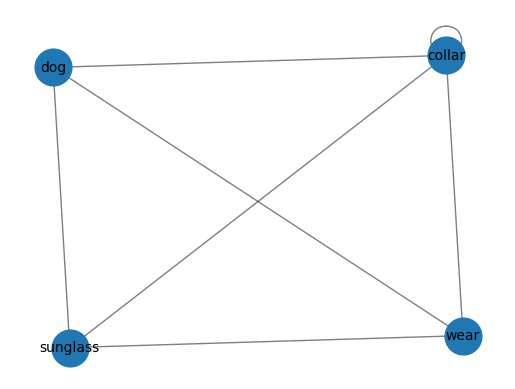

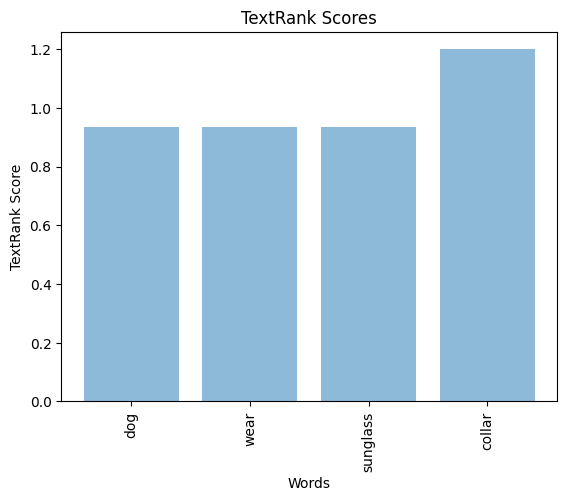

In [ ]:
#visualizing what is happening above
import networkx as nx
import matplotlib.pyplot as plt

# Visualizes the graph
def visualizeGraph(graph):
    pos = nx.spring_layout(graph)  # positions for all nodes
    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=700)
    # edges
    nx.draw_networkx_edges(graph, pos, width=1.0, alpha=0.5)
    # labels
    nx.draw_networkx_labels(graph, pos, font_size=10, font_family="sans-serif")
    plt.axis("off")
    plt.show()

# Visualizes the TextRank scores
def visualizeScores(scores):
    plt.bar(scores.keys(), scores.values(), align="center", alpha=0.5)
    plt.xlabel("Words")
    plt.ylabel("TextRank Score")
    plt.title("TextRank Scores")
    plt.xticks(rotation=90)
    plt.show()

# visualizing the example
words = preprocessing(text_caption)
theGraph = buildGraph(words)
visualizeGraph(theGraph)
visualizeScores(textRank(theGraph))

In [ ]:
#song recommendation code
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

#dataset
songs = pd.read_csv('spotify_millsongdata.csv')

#preprocessing the dataset
songs.drop("link", axis=1, inplace=True)
songs['text'] = songs['text'].str.replace(r'\n', '')

#TF-IDF vectorization
tfidf = TfidfVectorizer(stop_words='english')
lyrics_matrix = tfidf.fit_transform(songs['text'])

#matching keywords to each song
def songRecommender(keywords):
  recommendations = {}
  for keyword in keywords:
    keyword_tfidf = tfidf.transform([keyword])
    #finds the similarity between the keywords
    keyword_similarity = cosine_similarity(keyword_tfidf, lyrics_matrix)
    for i, song in enumerate(songs['text']):
        if song not in recommendations:
            recommendations[song] = keyword_similarity[0][i]
        else:
            recommendations[song] += keyword_similarity[0][i]
  #rank song based on the aggregated similarity scores
  ranked_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
  return ranked_recommendations

#the code being used with the keywords depicted in the codeblock above
recommendations = songRecommender(keywords)

num_recommendations = 5 #global variable that will be used to extract the top 5

In [ ]:
#function that shows why the song was chosen
for song, similarity_score in recommendations[:num_recommendations]:
    print("Lyrics:", song)
    print("Similarity Score:", similarity_score)
    print()  #make the lyrics readable

Lyrics: Do the dog, do the dog  
Do the dog now, baby  
Come on, do the dog, yeah  
Do the gog  
Everybody's doin' the dog  
Come on, hey baby  
  
Do the hound dog, yeah  
Do the hound dog, baby, come on  
Let's do the hound dog, baby  
Do the hound dog, yeah  
Do the dog  
Everybody's doin' the dog  
  
Do the bird dog, yeah  
Do the bird dog, yeah  
Do the bird dog, baby, come on  
And do the bird dog, yeah  
Do the dog  
Everybody's doin' the dog  
Come on  
  
Do the bird dog  
Do the hound dog  
Do the poodle, any kind of dog  
Let's do the dog  
Do the dog  
Everybody, let's do the dog  
  
Come on, baby  
Let's walk this dog now  
Oh just-a, just-a, just-a walkin'  
Just-a, just-a, just-a walkin'  
Just-a, just-a, just-a walkin'  
Let's do the dog  
Then we'll walk the dog  
Come on, baby  
Let's walk it one more time


Similarity Score: 0.8868902511786174

Lyrics: Are you tired of staying home and being lonely  
Walk the dog (walk the dog)  
Walk the dog (walk the dog)  
Would

In [ ]:
def printTopFive(recommendations, num_recommendations):
    top_five = []
    for song, similarity_score in recommendations[:num_recommendations]:
        song_info = songs[songs['text'] == song].iloc[0]
        song_name = song_info['song']
        artist = song_info['artist']
        top_five.append((song_name, artist, similarity_score))
    return top_five if top_five else []

#function in action, using the examples that has been explored so far
printTopFive(recommendations, num_recommendations) #will also run with songRecommender(keywords) in place of recommendations

[('The Dog', 'Otis Redding', 0.8868902511786174),
 ('Walk The Dog', 'Eddie Cochran', 0.8603579701206896),
 ("I'm A Dog", 'Gucci Mane', 0.821847132798616),
 ('Dog Eat Dog', 'Weird Al Yankovic', 0.7890766977764615),
 ('Move It On Over', 'Hank Williams', 0.7846605045501105)]

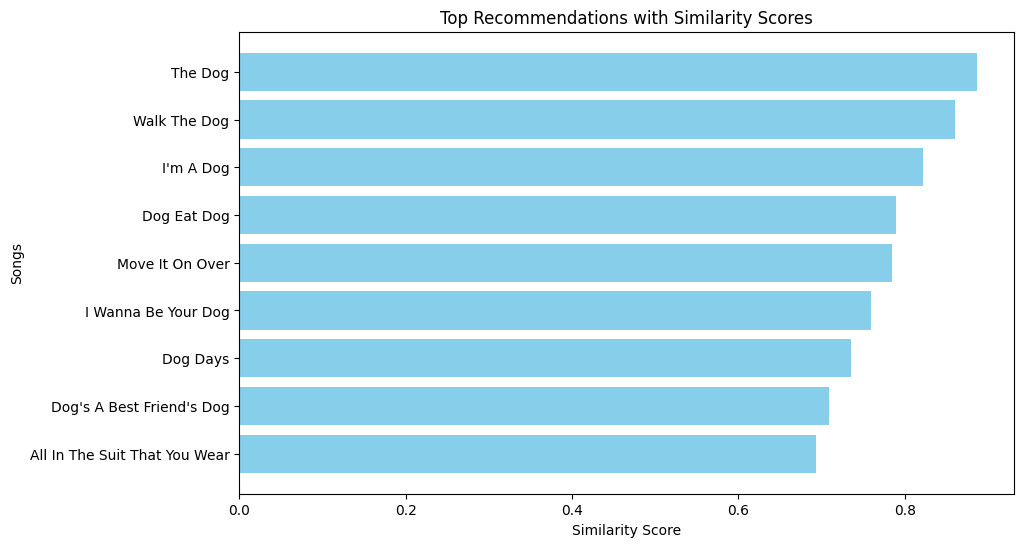

In [ ]:
#function to visualize the top recommendations (used in the report)
def visualizeTopRecommendations(topRecs):
    if not topRecs:
        print("No recommendations to visualize.")
        return

    # Extract song names, artists, and similarity scores
    song_names = [recommendation[0] for recommendation in topRecs]
    artists = [recommendation[1] for recommendation in topRecs]
    similarity_scores = [recommendation[2] for recommendation in topRecs]

    # Create bar graph
    plt.figure(figsize=(10, 6))
    plt.barh(song_names, similarity_scores, color='skyblue')
    plt.xlabel('Similarity Score')
    plt.ylabel('Songs')
    plt.title('Top Recommendations with Similarity Scores')
    plt.gca().invert_yaxis()  # Invert y-axis to display the highest similarity at the top
    plt.show()

topRecs = printTopFive(recommendations, 10)
visualizeTopRecommendations(topRecs)

In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00


In [ ]:
# Interface
import streamlit as st

# Streamlit app
def main():
    st.title("Playlist Recommendation from Image Captioning")

    image_url = st.text_input("Paste the URL link of the image:")
    if st.button("Generate Playlist"):
        # need to write the image captioning again for the interface since the first code was used for demonstration how this works
        if image_url:
            raw_image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
            contains_person = True
            text = "a photography of"

            # Conditional image captioning
            inputs = processor(raw_image, text, return_tensors="pt")
            out = model.generate(**inputs)
            conditional_caption_variable = processor.decode(out[0], skip_special_tokens=True)

            # Unconditional image captioning
            inputs = processor(raw_image, return_tensors="pt")
            out = model.generate(**inputs)
            unconditional_caption_variable = processor.decode(out[0], skip_special_tokens=True)

            if contains_person:
                text_caption = conditional_caption_variable
            else:
                text_caption = unconditional_caption_variable

            st.write("Input Image Caption:", text_caption)

            # keywords extraction from image caption above
            keywords = extractKeywords(text_caption)

            # Recommend songs based on keywords
            recommended_songs = songRecommender(keywords)

            # Display top5 recommendations
            top_five_songs = printTopFive(recommended_songs, 5)
            st.write("Top 5 Recommended Songs:")
            for idx, (song_name, artist, similarity_score) in enumerate(top_five_songs):
                st.write(f"{idx+1}. {song_name} by {artist} (Similarity Score: {similarity_score:.2f})")

if __name__ == "__main__":
    main()

2024-05-12 23:26:22.131 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-05-12 23:26:22.136 Session state does not function when running a script without `streamlit run`
